# Fréchet distance

This will compare the performance of calculating the discrete Fréchet distance with the recursive and dynamic programming algorithms.

In [1]:
import similaritymeasures as sm
import numpy as np
import matplotlib.pyplot as plt
import toleranceinterval as ti
from scipy.spatial import minkowski_distance
from time import time


In [2]:
def dp_frechet_dist(P, Q, pnorm=2):
    """ dynamic programming for discrete frechet distance
    
    by SenZHANG https://github.com/SenZHANG-GitHub
    https://github.com/cjekel/similarity_measures/issues/6#issuecomment-544350039
    """
    n = len(P)
    m = len(Q)
    ca = np.ones((n, m))
    ca = np.multiply(ca, -1)
    ca[0, 0] = minkowski_distance(P[0], Q[0], p=pnorm)
    for i in range(1, n):
        ca[i, 0] = max(ca[i-1, 0], minkowski_distance(P[i], Q[0], p=pnorm))
    for j in range(1, m):
        ca[0, j] = max(ca[0, j-1], minkowski_distance(P[0], Q[j], p=pnorm))
    for i in range(1, n):
        for j in range(1, m):
            ca[i, j] = max(min(ca[i-1, j], ca[i, j-1], ca[i-1, j-1]), minkowski_distance(P[i], Q[j], p=pnorm))
    return ca[n-1, m-1]

In [3]:
def benchmark_frechet(sizes, method, seed):
    np.random.seed(seed)
    n_dim = 5
    n_rep = 100
    times = np.zeros((len(sizes), n_rep))
    for i, size in enumerate(sizes):
        for j in range(n_rep):
            P = np.random.random((size, n_dim))
            Q = np.random.random((size, n_dim))
            t0 = time()
            d = method(P, Q)
            t1 = time()
            times[i, j] = t1 - t0
    return times

In [4]:
sizes = [20, 40, 50, 100, 200, 400, 500, 1000]
# recursion times
times_recursion = benchmark_frechet(sizes, sm.frechet_dist, 123)
# dynamic programming times
times_dp = benchmark_frechet(sizes, dp_frechet_dist, 123)

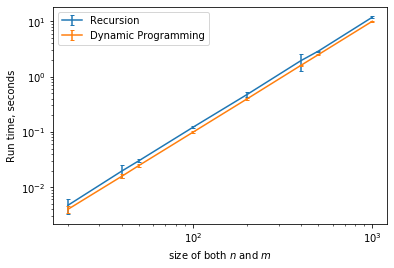

In [5]:
# compute means of runtimes
times_recursion_mean = times_recursion.mean(axis=1)
times_dp_mean = times_dp.mean(axis=1)

# compute the 99th percntile to 99% confidence
bounds_recursion = ti.twoside.normal(times_recursion, 0.99, 0.99)
bounds_dp = ti.twoside.normal(times_dp, 0.99, 0.99)

# get the - and plus values for error bars
k_sigma_recursion = bounds_recursion[:, 1] - times_recursion_mean
k_sigma_dp = bounds_dp[:, 1] - times_dp_mean

fig = plt.figure()

plt.errorbar(sizes, times_recursion_mean,
             yerr=k_sigma_recursion,
             capsize=2.0,
             label='Recursion')
plt.errorbar(sizes, times_dp_mean,
             yerr=k_sigma_dp,
             capsize=2.0,
             label='Dynamic Programming')

plt.semilogx(True)
plt.semilogy(True)
plt.xlabel(r'size of both $n$ and $m$')
plt.ylabel('Run time, seconds')
plt.legend()


In [6]:
bounds_dp

array([[3.44202367e-03, 4.50518283e-03],
       [1.43606370e-02, 1.71280056e-02],
       [2.35760593e-02, 2.60690833e-02],
       [9.53312417e-02, 1.02528656e-01],
       [3.84261025e-01, 4.05437513e-01],
       [1.56694557e+00, 1.62862086e+00],
       [2.46232444e+00, 2.52240927e+00],
       [9.83034253e+00, 1.01670652e+01]])

In [7]:
k_sigma_dp

array([0.00053158, 0.00138368, 0.00124651, 0.00359871, 0.01058824,
       0.03083765, 0.03004241, 0.16836134])

In [8]:
times_recursion_mean

array([4.69427109e-03, 1.95678020e-02, 3.02675223e-02, 1.21580572e-01,
       4.73871052e-01, 1.94466767e+00, 2.88474394e+00, 1.18369269e+01])

In [9]:
times_dp_mean

array([3.97360325e-03, 1.57443213e-02, 2.48225713e-02, 9.89299488e-02,
       3.94849269e-01, 1.59778322e+00, 2.49236686e+00, 9.99870387e+00])

In [10]:
times_recursion_mean/times_dp_mean

array([1.18136381, 1.24284823, 1.21935484, 1.22895618, 1.20013152,
       1.21710358, 1.15743151, 1.18384613])

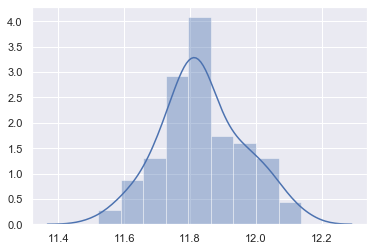

In [11]:
import seaborn as sns
sns.set()
sns.distplot(times_recursion[-1])

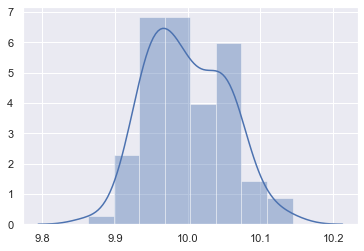

In [12]:
sns.distplot(times_dp[-1])

# Conclusion

**The iterative code was about 1.2 times faster (on average, with 5 dimensions) than the recursive code.** The iterative code also has the benefit of not dealing with recursion limits. I think it's time to replace the recursive code.

In [13]:
sm.__version__

'0.3.4'